**This file is for generating figures to visualize the core clock genes in WT/CTL vs APP/AD subjects (as seen in figures1, 2).**

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi
import pandas as pd
import itertools
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
core_clock = ["Ciart", "Arntl", "Npas2", "Clock", "Cry1",  "Cry2", 
              "Nr1d1", "Nr1d2", "Per1",  "Per2",  "Per3"  ,"Dbp",  "Tef", "Nfil3" ]

**MOUSE JTK DATA**

In [3]:
def read_and_filter_mouse_data(ipbulk_filename, astros_filename, mglia_filename):
    ipbulk = pd.read_csv(ipbulk_filename)
    ipbulk['CycID'] = ipbulk['CycID'].str.split('_').str[1]
    ipbulk = ipbulk[ipbulk['BH.Q'] < 0.2]

    astros = pd.read_csv(astros_filename)
    astros['CycID'] = astros['CycID'].str.split('_').str[1]
    astros = astros[astros['BH.Q'] < 0.2]

    mglia = pd.read_csv(mglia_filename)
    mglia['CycID'] = mglia['CycID'].str.split('_').str[1]
    mglia = mglia[mglia['BH.Q'] < 0.2]
    
    # Perform the first join between ipbulk and astros on 'CycID'
    merged_df = pd.merge(ipbulk, astros, on='CycID', how='outer', suffixes= ["_ipbulk", "_astros"])

    # Perform the second join with mglia on 'CycID'
    merged_df = pd.merge(merged_df, mglia, on='CycID', how='outer')
    
    df_filtered = merged_df[merged_df['CycID'].isin(core_clock)]
    df_filtered = df_filtered.loc[:, ["CycID", "LAG_ipbulk", "LAG_astros", "LAG"]]
    column_rename_mapping = {
        'CycID': 'Gene Symbols',
        'LAG_ipbulk': 'Bulk',
        'LAG_astros': 'Astrocyte',
        'LAG':'Microglia'
    }

    # Use the rename method to rename columns
    df_filtered.rename(columns=column_rename_mapping, inplace=True)
    return(df_filtered)

desired_order = ["Per2", "Cry1", "Arntl", "Nr1d1", "Per3", "Ciart", "Dbp", "Nr1d2", "Tef", "Per1"]
WT_data = read_and_filter_mouse_data('JTKresult_bulk_WT_data.csv', 'JTKresult_astro_WT_data.csv', 'JTKresult_micro_WT_data.csv')

# WT_data = WT_data.iloc[[10, 2,  0, 7, 11, 1, 4, 8, 12, 9],:]
# Set 'Gene Symbols' as the index
WT_data = WT_data.set_index('Gene Symbols')

# Reindex based on the desired order
WT_data = WT_data.reindex(desired_order).reset_index()

APP_data = read_and_filter_mouse_data('JTKresult_bulk_APP_data.csv', 'JTKresult_astro_APP_data.csv', 'JTKresult_micro_APP_data.csv')
# APP_data = APP_data.iloc[[7,2,0,4,8,1,3,5,9,6], :]
APP_data = APP_data.set_index('Gene Symbols')
APP_data = APP_data.reindex(desired_order).reset_index()

#create datadrame with WT genes/acrophases then APP genes/acrophases for plotting
mouse_df = pd.concat([WT_data, APP_data], ignore_index=True)
mouse_df


,Gene Symbols,Bulk,Astrocyte,Microglia
0,Per2,0.0,0.0,0.0
1,Cry1,1.0,2.0,1.0
2,Arntl,8.0,7.0,7.0
3,Nr1d1,17.0,NaN,18.0
4,Per3,18.0,22.0,22.0
5,Ciart,19.0,19.0,19.0
6,Dbp,19.0,19.0,20.0
7,Nr1d2,NaN,NaN,20.0
8,Tef,23.0,22.0,0.0
9,Per1,NaN,22.0,1.0


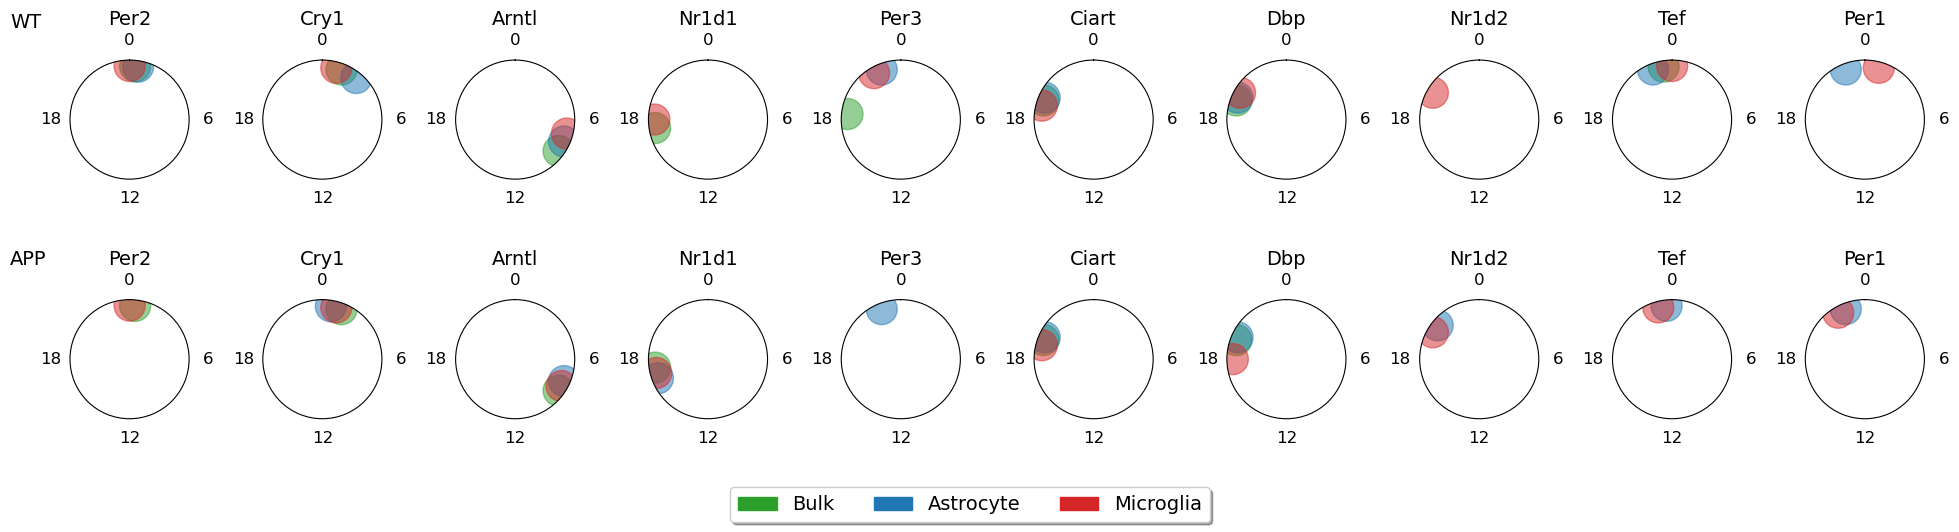

In [4]:

def plot_figure(dataframe, num_genes):
    f, axes = plt.subplots(2, num_genes,figsize = (20, 5), subplot_kw=dict(projection="polar"))
    colors = {'Astrocyte':'tab:blue', 'Microglia':'tab:red', 'Bulk':'tab:green'}
    np.random.seed(1)

    #generate array of 8 values that follow normal distribution with mean=5 and sd=2
    jitter =  np.random.rayleigh(scale=.1, size=3)
    row = 0

    for i in range(dataframe.shape[0]):
        col = i
        if (i > num_genes - 1):
            row = 1
            col = i % num_genes
        angles = dataframe.iloc[i, 1:4]*pi/12 + jitter #convert to radians and add jitter
        scatter = axes[row, col].scatter(angles, np.ones(3)*1-.1, c = dataframe.columns[1:4].map(colors), alpha = 0.50, s = 500)
        plt.setp(axes[row, col].get_yticklabels(), visible=False)

        axes[row, col].set_title(dataframe.iloc[i, 0], fontsize = 14)
        axes[row, col].set_ylim(0, 1)
        axes[row, col].set_xticks(np.linspace(0, 2*pi, 4, endpoint=False))
        axes[row, col].set_xticklabels([0, 6 ,12, 18], fontsize = 12)

        # make the labels go clockwise
        axes[row, col].set_theta_direction(-1)

        # place 0 at the top
        axes[row, col].set_theta_offset(pi/2.0)
        #axes[i].bar(angles, np.full(3, 0.9), width=0.05, bottom=0.2, linewidth=3)
        axes[row, col].grid(visible = False)
        # produce a legend with the unique colors from the scatter
        # legend1 = axes[i].legend(*scatter.legend_elements(),
                        # loc="lower left", title="Classes")
        # axes[i].add_artist(legend1)

    f.tight_layout(pad=1.5)

    red_patch = mpatches.Patch(color='tab:red', label='Microglia')
    green_patch = mpatches.Patch(color='tab:green', label='Bulk')
    blue_patch = mpatches.Patch(color='tab:blue', label='Astrocyte')
    plt.gcf().text(0.02, 0.425, "APP", fontsize=14)
    plt.gcf().text(0.02, 0.9, "WT", fontsize=14)
    f.legend(handles=[green_patch, blue_patch, red_patch],loc='upper center', bbox_to_anchor=(0.5, 0),fancybox=True, shadow=True, ncol=3, fontsize = 14)
    plt.subplots_adjust(left=0.05)
    plt.show()
    
plot_figure(mouse_df, num_genes = 10)

**Human Data Results from CYCLOPS**

In [19]:
# EN_cycling_CTL = "../../Cyclops_ordering/downstream_output_Exc3_5/cosinor_results_CTL.csv"
# EN_cycling_AD = "../../Cyclops_ordering/downstream_output_Exc3_5/cosinor_results_AD.csv"
EN_cycling_CTL = "../../Cyclops_ordering/downstream_output_Exc_All/cosinor_results_CTL.csv"
EN_cycling_AD = "../../Cyclops_ordering/downstream_output_Exc_All/cosinor_results_AD.csv"

IN_cycling_CTL = "../../Cyclops_ordering/downstream_output_Inhib_All/cosinor_results_CTL.csv"
IN_cycling_AD = "../../Cyclops_ordering/downstream_output_Inhib_All/cosinor_results_AD.csv"

AS_cycling_CTL = "../../Cyclops_ordering/downstream_output_Ast_All/cosinor_results_CTL.csv"
AS_cycling_AD = "../../Cyclops_ordering/downstream_output_Ast_All/cosinor_results_AD.csv"

MG_cycling_CTL = "../../Cyclops_ordering/downstream_output_Mglia_All/cosinor_results_CTL.csv"
MG_cycling_AD = "../../Cyclops_ordering/downstream_output_Mglia_All/cosinor_results_AD.csv"

core_clock = [x.upper() for x in core_clock]
#Read in CTL cosinor results from Exc cell type
EN = pd.read_csv(EN_cycling_CTL)
#Get phase of ARNTL so I can subtract it from all phases (Align ARNTL to 0)
ARNTL_shift = EN.loc[EN["Gene_Symbols"] == "ARNTL"]["acrophase"].iloc[0]
print("ARNTL is at {} in Exc".format(ARNTL_shift))

def read_and_filter_human_data(EN_filename, IN_filename, AS_filename, MG_filename, shift = 0., BHQ_cutoff = 0.1):
    EN = pd.read_csv(EN_filename)
    EN = EN[EN['BHQ'] < BHQ_cutoff]


    IN = pd.read_csv(IN_filename)
    IN = IN[IN['BHQ'] < BHQ_cutoff]

    AS = pd.read_csv(AS_filename)
    AS = AS[AS['BHQ'] < BHQ_cutoff]

    MG = pd.read_csv(MG_filename)
    MG = MG[MG['BHQ'] < BHQ_cutoff]

    # Perform the first join between EN and IN on 'Gene_Symbols'
    merged_df_EN_IN = pd.merge(EN, IN, on='Gene_Symbols', how='outer', suffixes= ["_EN", "_IN"])

    # Perform the second join with Astros on 'Gene_Symbols'
    merged_df2_MG_AS = pd.merge(MG, AS, on='Gene_Symbols', how='outer', suffixes = ["_MG", "_AS"])
    merged_df = pd.merge(merged_df_EN_IN, merged_df2_MG_AS, how = "outer")

    df_filtered = merged_df[merged_df['Gene_Symbols'].isin(core_clock)]
    df_filtered = df_filtered.loc[:, ["Gene_Symbols", "acrophase_EN", "acrophase_IN", "acrophase_AS", "acrophase_MG"]]
    column_rename_mapping = {
        'Gene_Symbols': 'Gene Symbols',
        'acrophase_EN': 'Excitatory Neurons',
        'acrophase_IN': 'Inhibitory Neurons',
        'acrophase_AS': 'Astrocytes',
        'acrophase_MG':'Microglia'
    }
    # Use the rename method to rename columns
    df_filtered.rename(columns=column_rename_mapping, inplace=True)
    

    # Function to perform the desired operations
    def shift_flip_phases(column):
        if column.dtypes.kind in 'biufc':
            return ((-1* (column - shift) ) % (np.pi * 2))
        return column

    # Apply the custom operation to all numeric values in the DataFrame
    df_filtered = df_filtered.apply(shift_flip_phases)

    return(df_filtered)

desired_order_hs = ["ARNTL", "CLOCK", "NR1D1" , "DBP","TEF","CIART", "PER2","PER3"] 

CTL_data = read_and_filter_human_data(EN_cycling_CTL, IN_cycling_CTL, AS_cycling_CTL, MG_cycling_CTL, shift =ARNTL_shift)
# Set 'Gene Symbols' as the index
CTL_data = CTL_data.set_index('Gene Symbols')
# Reindex based on the desired order
CTL_data = CTL_data.reindex(desired_order_hs).reset_index()

AD_data = read_and_filter_human_data(EN_cycling_AD, IN_cycling_AD, AS_cycling_AD, MG_cycling_AD, shift = ARNTL_shift)
AD_data = AD_data.set_index('Gene Symbols')
AD_data = AD_data.reindex(desired_order_hs).reset_index()


#create datadrame with CTL genes/acrophases then AD genes/acrophases for plotting
human_df = pd.concat([CTL_data, AD_data], ignore_index=True)
human_df


ARNTL is at 5.38483587334368 in Exc


,Gene Symbols,Excitatory Neurons,Inhibitory Neurons,Astrocytes,Microglia
0,ARNTL,0.000000,6.107782,6.173539,0.448239
1,CLOCK,0.084020,0.831674,5.837299,0.096487
2,NR1D1,0.759313,NaN,NaN,NaN
3,DBP,2.265512,2.354216,3.200587,2.724241
4,TEF,1.554341,1.522376,3.945145,NaN
5,CIART,2.697255,2.762416,3.524245,NaN
6,PER2,3.762158,3.747818,NaN,3.553729
7,PER3,6.086776,6.110557,4.265536,3.920448
8,ARNTL,0.213547,6.197760,6.276380,0.192294
9,CLOCK,0.182414,0.614411,NaN,0.151442


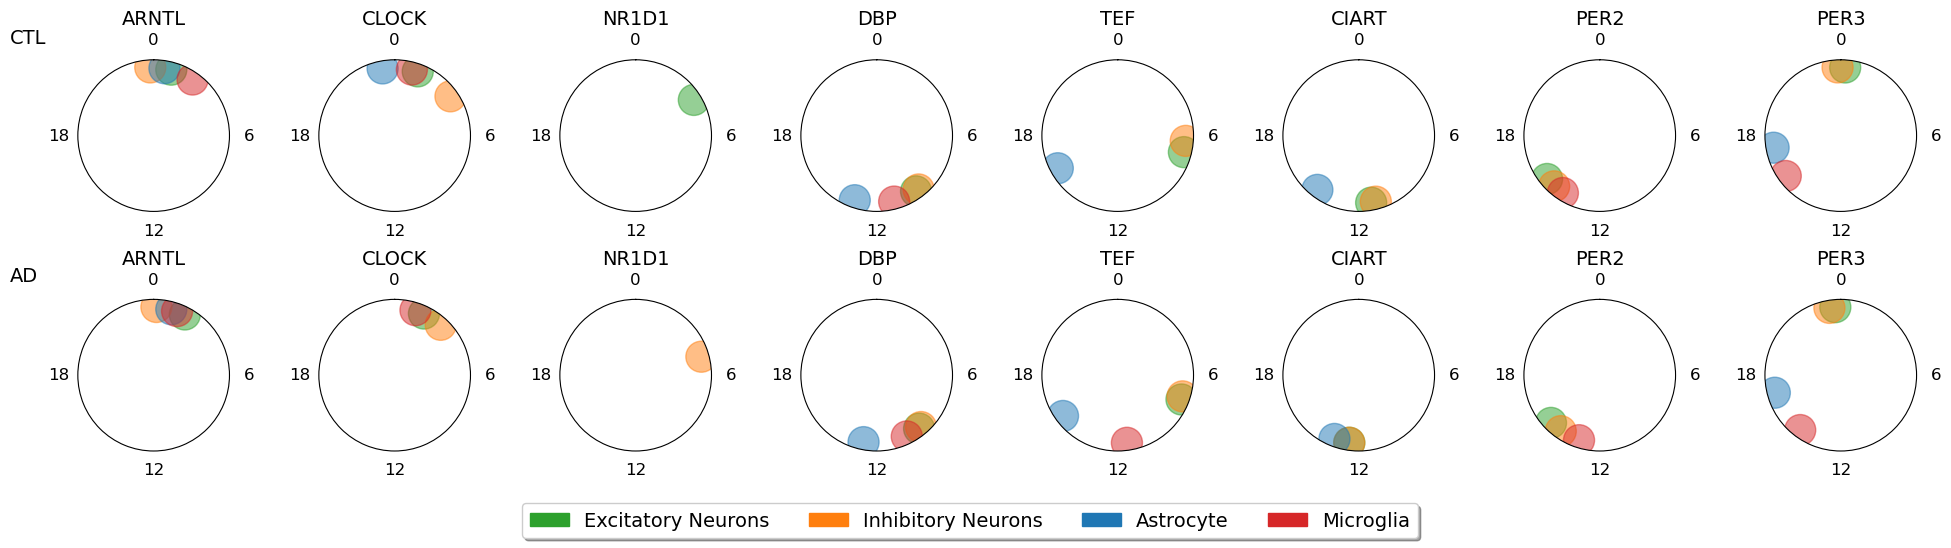

In [20]:
num_genes =8
dataframe = human_df
def plot_human_figure(dataframe, num_genes):
    f, axes = plt.subplots(2, num_genes,figsize = (20, 5), subplot_kw=dict(projection="polar"))
    colors = {'Astrocytes':'tab:blue', 'Microglia':'tab:red', 'Excitatory Neurons':'tab:green', 'Inhibitory Neurons':'tab:orange'}
    np.random.seed(1) #was using this originally, but DBP was overlapping
    np.random.seed(4)

    #generate array of 8 values that follow normal distribution with mean=5 and sd=2
    jitter =  np.random.rayleigh(scale=.1, size=4)
    row = 0

    for i in range(dataframe.shape[0]):
        col = i
        if (i > num_genes - 1):
            row = 1
            col = i % num_genes
        angles = dataframe.iloc[i, 1:5] + jitter #convert to radians and add jitter
        scatter = axes[row, col].scatter(angles, np.ones(4)*1-.1, c = dataframe.columns[1:5].map(colors), alpha = 0.50, s = 500)
        plt.setp(axes[row, col].get_yticklabels(), visible=False)

        axes[row, col].set_title(dataframe.iloc[i, 0], fontsize = 14)
        axes[row, col].set_ylim(0, 1)
        axes[row, col].set_xticks(np.linspace(0, 2*pi, 4, endpoint=False))
        axes[row, col].set_xticklabels([0, 6 ,12, 18], fontsize = 12)

        # make the labels go clockwise
        axes[row, col].set_theta_direction(-1)

        # place 0 at the top
        axes[row, col].set_theta_offset(pi/2.0)
        #axes[i].bar(angles, np.full(3, 0.9), width=0.05, bottom=0.2, linewidth=3)
        axes[row, col].grid(visible = False)
        # produce a legend with the unique colors from the scatter
        # legend1 = axes[i].legend(*scatter.legend_elements(),
                        # loc="lower left", title="Classes")
        # axes[i].add_artist(legend1)

    f.tight_layout(pad=1.5)

    red_patch = mpatches.Patch(color='tab:red', label='Microglia')
    green_patch = mpatches.Patch(color='tab:green', label='Excitatory Neurons')
    orange_patch = mpatches.Patch(color='tab:orange', label='Inhibitory Neurons')
    blue_patch = mpatches.Patch(color='tab:blue', label='Astrocyte')
    plt.gcf().text(0.02, 0.425, "AD", fontsize=14)
    plt.gcf().text(0.02, 0.9, "CTL", fontsize=14)
#     f.legend(handles=[green_patch, orange_patch, blue_patch, red_patch], loc = 'upper right')


    # Put a legend to the right of the current axis
    f.legend(handles=[green_patch, orange_patch, blue_patch, red_patch],loc='upper center', bbox_to_anchor=(0.5, 0),fancybox=True, shadow=True, ncol=4, fontsize = 14)
    plt.subplots_adjust(left=0.05)
    plt.show()
    
plot_human_figure(human_df, num_genes)